In [1]:
import pymysql
import tensorflow as tf
from sqlalchemy import create_engine
import pandas as pd

# GPU 설정
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU 설정 완료:", gpus[0])
    except RuntimeError as e:
        print(e)

# 데이터베이스 연결 함수
def get_db():
    db = pymysql.connect(
        host='human-mysql.mysql.database.azure.com',  # Azure MySQL Host
        port=3306,  # Port number (MySQL default is 3306)
        user='human',  # Username
        passwd='!q1w2e3r4',  # Password
        db='humandb',  # Database name
        ssl_ca=r'/home/azureuser/Desktop/config/DigiCertGlobalRootG2.crt.pem'  # SSL certificate path
    )
    return db

# DB에서 데이터 로드
db_connection = get_db()
cursor = db_connection.cursor()

query = "SELECT * FROM humandb.modeling"
cursor.execute(query)
columns = [desc[0] for desc in cursor.description]  # 컬럼 이름 가져오기
all_data = cursor.fetchall()  # 데이터 가져오기

# Pandas DataFrame으로 변환
df = pd.DataFrame(all_data, columns=columns)

# 데이터 확인
print("데이터셋의 크기:", df.shape)
print("컬럼명:", df.columns)

2025-02-26 01:20:41.938564: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-26 01:20:41.941258: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-26 01:20:41.948631: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740532841.960582  981319 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740532841.964180  981319 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-26 01:20:41.977373: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

데이터셋의 크기: (100330, 17)
컬럼명: Index(['Index', 'HeartRate', 'BreathRate', 'SPO2', 'SkinTemperature',
       'SleepPhase', 'SleepScore', 'WalkingSteps', 'StressIndex',
       'ActivityIntensity', 'CaloricExpenditure', '심박', '호흡', '피부온도', '혈중산소농도',
       '일상', '상태'],
      dtype='object')


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100330 entries, 0 to 100329
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Index               100330 non-null  int64  
 1   HeartRate           100330 non-null  int64  
 2   BreathRate          100330 non-null  int64  
 3   SPO2                100330 non-null  int64  
 4   SkinTemperature     100330 non-null  float64
 5   SleepPhase          100330 non-null  int64  
 6   SleepScore          100330 non-null  int64  
 7   WalkingSteps        100330 non-null  int64  
 8   StressIndex         100330 non-null  int64  
 9   ActivityIntensity   100330 non-null  int64  
 10  CaloricExpenditure  100330 non-null  int64  
 11  심박                  100330 non-null  int64  
 12  호흡                  100330 non-null  int64  
 13  피부온도                100330 non-null  int64  
 14  혈중산소농도              100330 non-null  int64  
 15  일상                  100330 non-nul

In [3]:
df.head()

,Index,HeartRate,BreathRate,SPO2,SkinTemperature,SleepPhase,SleepScore,WalkingSteps,StressIndex,ActivityIntensity,CaloricExpenditure,심박,호흡,피부온도,혈중산소농도,일상,상태
0,0,73,16,98,0.0,9,0,0,0,102,0,0,0,0,0,1,0
1,1,73,16,98,0.0,9,0,0,0,0,0,0,0,0,0,1,0
2,2,73,16,98,0.0,9,0,0,0,0,0,0,0,0,0,1,0
3,3,74,16,98,0.0,9,0,0,0,0,0,0,0,0,0,1,0
4,4,74,16,98,0.0,9,0,0,0,0,0,0,0,0,0,1,0


In [9]:
from tensorflow import keras
import sklearn as sk
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score

### 다중 클래스

In [10]:
# 다중 라벨 컬럼 선택
y = df[['상태']]  # 다중 라벨 대상

# 입력 데이터(X) 설정
x = df.drop(columns=['Index', '심박', '호흡', '피부온도', '혈중산소농도','일상','상태'])  # 독립 변수


# 데이터의 shape 확인
print("x (입력 데이터) shape:", x.shape)
print("y (출력 데이터) shape:", y.shape)

x (입력 데이터) shape: (100330, 10)
y (출력 데이터) shape: (100330, 1)


In [11]:
# 데이터 준비 (예제 데이터베이스 연결 코드 생략)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# 모델 정의
keras.backend.clear_session()
input_layer = keras.layers.Input(shape=(10,))
d1 = keras.layers.Dense(512, activation='relu')(input_layer)
d2 = keras.layers.Dense(256, activation='relu')(d1)
d3 = keras.layers.Dense(128, activation='relu')(d2)
d4 = keras.layers.Dense(56, activation='relu')(d3)
output_layer = keras.layers.Dense(3, activation='softmax')(d4)

model = keras.models.Model(inputs=input_layer, outputs=output_layer)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# EarlyStopping 설정
es = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    restore_best_weights=True
)
# 모델 학습
with tf.device("GPU:0"):
    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        callbacks=[es],
        verbose=1,
        epochs=50
    )

# ✅ 5. 모델 평가
with tf.device("/GPU:0"):
    test_loss, test_accuracy = model.evaluate(x_test, y_test)

# ✅ 6. 예측값 생성 (소프트맥스 확률값 반환)
y_pred_prob = model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# ✅ 7. 로그 손실 (Log Loss) 계산
logloss = log_loss(y_test, y_pred_prob)

# ✅ 8. AUROC 계산 (One-vs-Rest 방식)
y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes=3)  # 원-핫 인코딩 변환
auroc = roc_auc_score(y_test_oh, y_pred_prob, multi_class="ovr")

# ✅ 9. 정확도 계산
accuracy = accuracy_score(y_test, y_pred)

# ✅ 10. 결과 출력
print(f"테스트 손실 (Log Loss): {logloss:.4f}")
print(f"테스트 AUROC: {auroc:.4f}")
print(f"테스트 정확도 (Accuracy): {accuracy:.4f}")

Epoch 1/50
2007/2007 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8511 - loss: 0.5850 - val_accuracy: 0.8820 - val_loss: 0.2736
Epoch 2/50
2007/2007 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8943 - loss: 0.2351 - val_accuracy: 0.9189 - val_loss: 0.1741
Epoch 3/50
2007/2007 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9255 - loss: 0.1650 - val_accuracy: 0.9380 - val_loss: 0.1400
Epoch 4/50
2007/2007 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9365 - loss: 0.1431 - val_accuracy: 0.9571 - val_loss: 0.1075
Epoch 5/50
2007/2007 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9447 - loss: 0.1263 - val_accuracy: 0.9563 - val_loss: 0.1022
Epoch 6/50
2007/2007 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9509 - loss: 0.1145 - val_accuracy: 0.9523 - val_loss: 0.1079
Epoch 7/50
2007/2007 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9579 - loss: 0.1006 - val_accuracy: 0.9253 - val_loss: 0.1571
Epoch 8/50
2007/2007 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9560 - loss: 0.1003 - 

ExactExplainer explainer: 20067it [49:41,  6.73it/s]                           


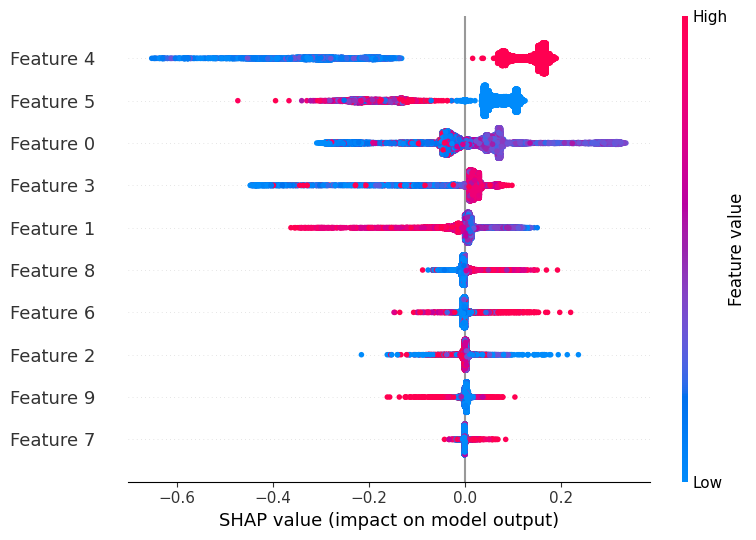

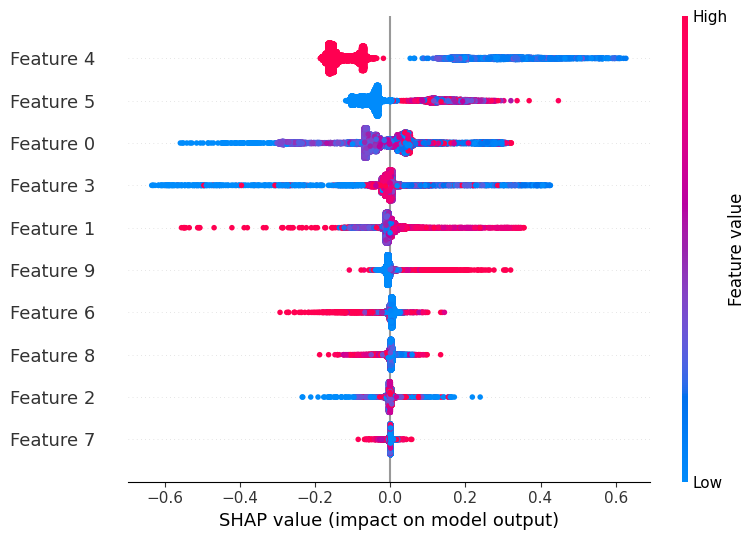

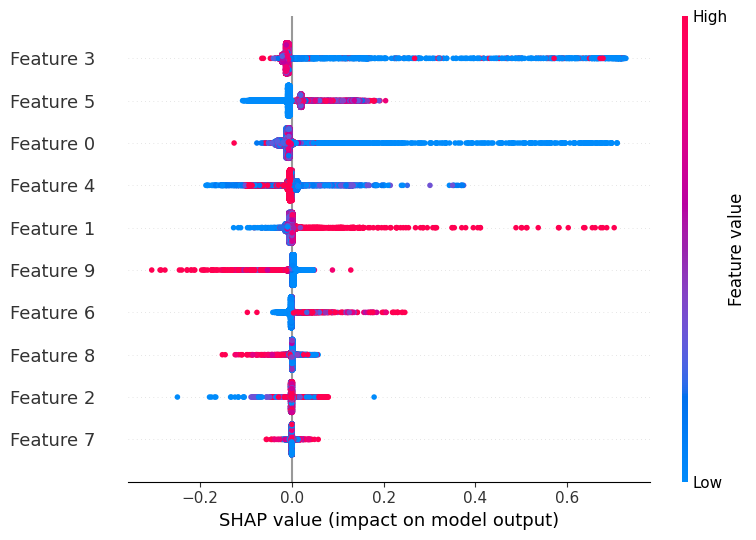

In [39]:
import shap
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# SHAP을 위한 Explainer 생성
explainer = shap.Explainer(model, x_train)

# SHAP 값 계산
shap_values = explainer(x_test)

# 클래스별 SHAP 중요도 시각화
for class_idx in range(shap_values.values.shape[-1]):
    shap.summary_plot(shap_values.values[..., class_idx], x_test, feature_names=[f'Feature {i}' for i in range(x_test.shape[1])])


In [15]:
# 상태(Status) 값이 1 또는 2인 데이터만 필터링
df_filtered = df[df["상태"].isin([1, 2])]

# ✅ 필터링된 데이터 출력
from IPython.display import display
display(df_filtered)

,Index,HeartRate,BreathRate,SPO2,SkinTemperature,SleepPhase,SleepScore,WalkingSteps,StressIndex,ActivityIntensity,CaloricExpenditure,심박,호흡,피부온도,혈중산소농도,일상,상태
356,356,80,24,98,-1.1,1,72,0,0,0,0,1,1,0,0,0,1
357,357,77,21,97,0.2,1,72,0,0,0,0,1,1,0,0,0,1
358,358,77,19,98,0.4,0,72,0,0,0,0,1,0,0,0,0,1
359,359,75,21,98,0.5,0,72,0,0,0,0,1,1,0,0,0,1
360,360,77,13,98,0.5,2,72,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100284,51539608288,78,21,98,-0.8,1,9,0,0,0,0,1,1,0,0,0,1
100285,51539608289,79,16,98,-0.6,1,9,0,0,0,0,1,0,0,0,0,1
100286,51539608290,82,20,98,-0.8,2,9,0,0,0,0,1,1,0,0,0,1
100287,51539608291,82,21,98,-0.4,1,9,0,0,0,0,1,1,0,0,0,1


### 다중 레이블


In [16]:
# 다중 라벨 컬럼 선택
y = df_filtered[['심박', '호흡', '피부온도', '혈중산소농도']]  # 다중 라벨 대상

# 입력 데이터(X) 설정
x = df_filtered.drop(columns=['Index', '심박', '호흡', '피부온도', '혈중산소농도','일상','상태'])  # 독립 변수


# 데이터의 shape 확인
print("x (입력 데이터) shape:", x.shape)
print("y (출력 데이터) shape:", y.shape)

x (입력 데이터) shape: (21526, 10)
y (출력 데이터) shape: (21526, 4)


In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.metrics import AUC
from sklearn.model_selection import train_test_split

# 데이터 준비 (예제 데이터베이스 연결 코드 생략)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# 모델 정의
keras.backend.clear_session()
input_layer = keras.layers.Input(shape=(10,))

d1 = Dense(512, activation='relu')(input_layer)
d1 = BatchNormalization()(d1)  # 배치 정규화 추가
d1 = Dropout(0.3)(d1)  # 드롭아웃 추가

d2 = Dense(256, activation='relu')(d1)
d2 = BatchNormalization()(d2)
d2 = Dropout(0.3)(d2)

d3 = Dense(128, activation='relu')(d2)
d3 = BatchNormalization()(d3)
d3 = Dropout(0.3)(d3)

d4 = Dense(128, activation='relu')(d3)
d4 = BatchNormalization()(d4)
d4 = Dropout(0.3)(d4)

output_layer = Dense(4, activation='sigmoid')(d3)

model = keras.models.Model(inputs=input_layer, outputs=output_layer)

# 모델 컴파일 (AUC 추가)
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', AUC(name='auc', multi_label=True)]
)

# EarlyStopping 설정 (min_delta 조정)
es = EarlyStopping(
    monitor='val_loss',
    min_delta=1e-4,  # 작은 변화 감지 가능
    patience=5,
    verbose=1,
    restore_best_weights=True
)

# 모델 학습
with tf.device("GPU:0"):
    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        callbacks=[es],
        verbose=1,
        epochs=50
    )

# 모델 평가
with tf.device("GPU:0"):
    test_loss, test_accuracy, test_auc = model.evaluate(x_test, y_test)

print(f"테스트 손실: {test_loss}, 테스트 정확도: {test_accuracy}, 테스트 AUC: {test_auc}")


Epoch 1/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4247 - auc: 0.5692 - loss: 0.6797 - val_accuracy: 0.4753 - val_auc: 0.7654 - val_loss: 0.5855
Epoch 2/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7127 - auc: 0.7868 - loss: 0.3749 - val_accuracy: 0.7387 - val_auc: 0.8714 - val_loss: 0.3349
Epoch 3/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7631 - auc: 0.8792 - loss: 0.3033 - val_accuracy: 0.8034 - val_auc: 0.9525 - val_loss: 0.3217
Epoch 4/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7900 - auc: 0.9239 - loss: 0.2525 - val_accuracy: 0.8406 - val_auc: 0.9611 - val_loss: 0.2153
Epoch 5/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7953 - auc: 0.9429 - loss: 0.2282 - val_accuracy: 0.8235 - val_auc: 0.9754 - val_loss: 0.1673
Epoch 6/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8037 - auc: 0.9551 - loss: 0.2085 - val_accuracy: 0.7933 - val_auc: 0.9707 - val_loss: 0.1933
Epoch 7/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 

### 설명

#### y_pred > 0.5: sigmoid에서 나온 확률 값을 0/1로 변환하여 평가.
#### Hamming Loss: 잘못 예측한 라벨의 비율 (낮을수록 좋음).
#### F1-Score (Micro, Macro): 정밀도(Precision)와 재현율(Recall)의 균형 평가.
#### Jaccard Score: 실제 라벨과 예측 라벨의 유사도를 평가.

In [23]:
from sklearn.metrics import f1_score, jaccard_score, hamming_loss

# 모델 예측 수행
y_pred = model.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # 0.5 이상이면 1, 아니면 0

# 평가 지표 계산
print("Hamming Loss:", hamming_loss(y_test, y_pred_binary))
print("Micro F1-Score:", f1_score(y_test, y_pred_binary, average='micro'))
print("Macro F1-Score:", f1_score(y_test, y_pred_binary, average='macro'))
print("Jaccard Score:", jaccard_score(y_test, y_pred_binary, average='samples'))


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Hamming Loss: 0.035647933116581515
Micro F1-Score: 0.9444243301955105
Macro F1-Score: 0.9074243411089176
Jaccard Score: 0.9312200030964546


In [24]:
import shap
import numpy as np

# 데이터가 Pandas DataFrame이면 NumPy 배열로 변환
x_train_np = x_train.values if hasattr(x_train, "values") else x_train
x_test_np = x_test.values if hasattr(x_test, "values") else x_test


In [25]:

# SHAP DeepExplainer 사용 (TensorFlow 기반 모델 + GPU)
with tf.device('/GPU:0'):  # GPU 사용 설정
    explainer = shap.DeepExplainer(model, x_train_np[:100])  # 일부 샘플 사용하여 속도 개선
    shap_values = explainer.shap_values(x_test_np)


/home/azureuser/anaconda3/envs/emergency/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/home/azureuser/anaconda3/envs/emergency/lib/python3.10/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(100, 10))']
  warnings.warn(msg)
/home/azureuser/anaconda3/envs/emergency/lib/python3.10/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(200, 10))'

In [ ]:
import pandas as pd
import shap
import numpy as np
import tensorflow as tf

# x_test를 NumPy 배열로 변환
x_test_np = np.array(x_test)
x_train_np = np.array(x_train)

# SHAP 객체 생성 (`DeepExplainer` 사용)
explainer = shap.DeepExplainer(model, x_train_np[:100])
shap_values = explainer.shap_values(x_test_np)

# SHAP 값 형태 확인
print(f"SHAP Value Type: {type(shap_values)}")
print(f"SHAP Value Shape: {np.shape(shap_values)}")  # (num_labels, num_samples, num_features)
print(f"Test Data Shape: {np.shape(x_test_np)}")

# 피처 이름 가져오기
feature_names = x.columns

# 라벨 개수 확인
num_labels = len(shap_values) if isinstance(shap_values, list) else 1

# SHAP 중요도 정리
shap_importance_df = pd.DataFrame()

for i in range(num_labels):
    # 라벨 i에 대한 피처 중요도 계산 (절댓값 평균)
    shap_importance = np.abs(shap_values[i]).mean(axis=0)

    # 데이터프레임으로 변환
    temp_df = pd.DataFrame({"Feature": feature_names, "SHAP Importance": shap_importance})
    temp_df = temp_df.sort_values(by="SHAP Importance", ascending=False)
    
    # 라벨 정보 추가
    temp_df["Label"] = f"Label {i}"
    
    # 결과 저장
    shap_importance_df = pd.concat([shap_importance_df, temp_df], axis=0)

# 라벨별로 SHAP Importance 출력
import ace_tools as tools  # Jupyter Notebook에서 데이터프레임 시각화 지원
tools.display_dataframe_to_user(name="SHAP Feature Importance", dataframe=shap_importance_df)


                    SHAP Importance
BreathRate                 0.114377
SkinTemperature            0.104239
HeartRate                  0.082162
CaloricExpenditure         0.023681
WalkingSteps               0.022426
SPO2                       0.020304
ActivityIntensity          0.007888
SleepScore                 0.004259
StressIndex                0.002952
SleepPhase                 0.001691


<Figure size 1000x500 with 0 Axes>

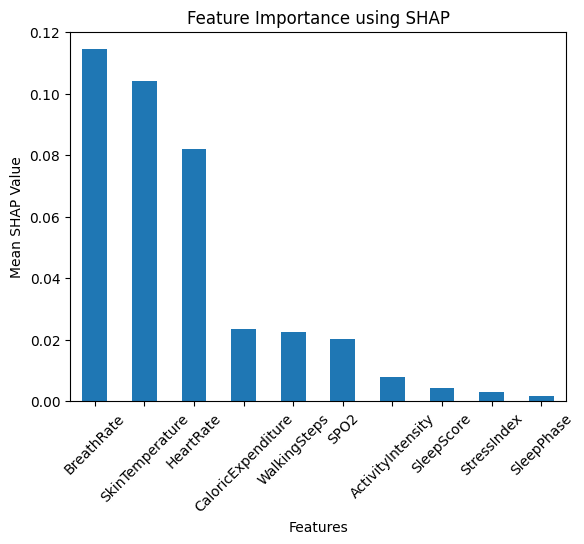

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 모든 클래스의 SHAP 값을 평균 내어 2D에서 1D로 변환
shap_mean = np.abs(shap_values).mean(axis=0).mean(axis=1)  # (10, 4) → (10,)

# DataFrame 변환 (실제 피처 이름 사용)
shap_df = pd.DataFrame(shap_mean, index=x_test.columns, columns=['SHAP Importance'])

# SHAP 평균값 정렬
shap_importance = shap_df.sort_values(by='SHAP Importance', ascending=False)

# SHAP 값 출력
print(shap_importance)

# SHAP 값 시각화
plt.figure(figsize=(10, 5))
shap_importance.plot(kind='bar', legend=False)
plt.title("Feature Importance using SHAP")
plt.xlabel("Features")
plt.ylabel("Mean SHAP Value")
plt.xticks(rotation=45)
plt.show()
